## Inference of Synthetic OCR Dataset Model

Description: I decided to put together an Inference-Only notebook to explain how to do inference on my TrOCR-trained projects.

#### Install Necessary Libraries

In [1]:
%pip install torch torchvision
%pip install transformers jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.4 MB/s eta 0:00:00


#### Import Necessary Libraries

In [2]:
import os, sys

from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import VisionEncoderDecoderModel, TrOCRProcessor

import PIL.Image
from PIL import Image

#### Display Library Versions

In [3]:
n = 14

print("Library".rjust(n), "| Version")
print("-" * (n +10))
print("Python".rjust(n), "|", sys.version[0:6])
print("Transformers".rjust(n), "|", transformers.__version__)
print("Torch".rjust(n), "|", torch.__version__)
print("PIL".rjust(n), "|", PIL.__version__)

       Library | Version
------------------------
        Python | 3.10.6
  Transformers | 4.31.0
         Torch | 2.0.1+cu118
           PIL | 8.4.0


#### Mount Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Access to HuggingFace Hub

In [5]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Ingest Image File to Run Inference on

In [6]:
parent_dir = "/content/drive/MyDrive/Colab Notebooks/TrOCR Synthetic Dataset/"

file_name = "17_IMG0037.jpg"

inference_file = os.path.join(parent_dir, file_name)

inference_file

'/content/drive/MyDrive/Colab Notebooks/TrOCR Synthetic Dataset/17_IMG0037.jpg'

#### Define Data Class

In [7]:
class Synthetic_Dataset_OCR_Dataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = PIL.Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

#### Define Processor & Model Checkpoints & Instantiate Both

In [8]:
PROCESSOR_CKPT = "microsoft/trocr-base-printed"

processor = TrOCRProcessor.from_pretrained(PROCESSOR_CKPT)

MODEL_NAME = "DunnBC22/trocr-base-printed-synthetic_dataset_ocr"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

#### Define Image DataLoader & Function to Generate Text in Image

In [9]:
def process_image(image):
    # Prepare image
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # Generate (no beam search)
    generated_ids = model.generate(pixel_values)

    # Decode
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_text

#### Display Image

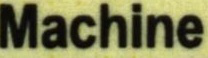

In [10]:
inference_image = Image.open(parent_dir + file_name).convert("RGB")

inference_image

#### Run Function to Generate Text in Image & Display Result

In [12]:
result = process_image(inference_image)

print(f'\nThe text for the image above is \'{result}\'.')


The text for the image above is 'MACHINE'.
